In [ ]:
# In this version, the label is created as follow:
# For each word in the reference, find the time overlap term in hyp.
# If it is the same word, label as 1, otherwise label as 0.
# For each instance of ref word, if none match word and time are found,
# label as "1" and prob as "0.0".
# Compared to v2, fix the issue that ref word instance is only compared
# with each hyp word, not entire hyp words at current time frame.

In [1]:
import sys
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, ranking

In [2]:
def compute_overlap(period1, period2):
    '''Compute the overlap percentage between two periods.
    Args:
    period1: list of [stime, etime], dtype=float
    period2: list of [stime, etime], dtype=float
    '''
    if (period2[1] - period1[0]) * (period1[1] - period2[0]) >= 0:
    # Overlap
        stime = max(period1[0], period2[0])
        etime = min(period1[1], period2[1])
        return (etime - stime) / (period1[1] - period1[0])
    else:
        return 0.

def check_duplicates(stored, current):
    '''Check if there are time overlap between the current word and 
    those alreay stored in list. If so only keep the one with largest probability.   
    Args:
    stored: [[begin_frame, duration, probability], [...], ...]
    current: [begin_frame, duration, probability]
    '''         
    overlap_flag = 1            
    update_stored = []
    for i, token in enumerate(stored):
        overlap = compute_overlap([token[0], token[1]], 
                                  [current[0], current[1]])
        if overlap > 0.:
            if token[2] >= current[2]:
                overlap_flag = 0
                update_stored.append(token)
        else:
            update_stored.append(token)
    if overlap_flag == 1:
        update_stored.append(current)
    return update_stored
            
def read_lattice_post(fname, chain_model_lats=False):
    dict_utt = {}
    with open(fname, 'r') as fid:
        for line in fid.readlines():
            tokens = line.strip().split()
            uttid = tokens.pop(0)
            tokens = [float(i) for i in tokens[:4]]
            word = str(int(tokens[3]))
            tokens[1] = tokens[0] + tokens[1]
            if chain_model_lats:
                tokens[0] *= 3
                tokens[1] *= 3
            if uttid in dict_utt.keys():
                if word in dict_utt[uttid].keys():
                    #dict_utt[uttid][word].append(tokens[:3])
                    dict_utt[uttid][word] = check_duplicates(dict_utt[uttid][word], tokens[:3])
                else:
                    dict_utt[uttid][word] = [tokens[:3]]
            else:
                dict_utt[uttid] = {}
                dict_utt[uttid][word] = [tokens[:3]]
            
    return dict_utt

def detect(ref_words_info, hyp_words_info, uttid, result_fid, overlap_thres=.5):
    '''Search reference word instance in all hypotheses and find matches in word-type and time.
    Both lists contains same words.
    If both match, print ref_word, 1, and hyp_probability;
    if only time matches, print ref_word, 0 and hyp_probability;
    otherwise return nothing.
    Args:
    ref_words_info: (ref_word: [begin_time, duration, probability])
    hyp_words_info: {hyp_word: [[begin_time, duration, probability], ...]}
    Return:
    results: List of results, format like
            e.g, [[ref_word, 1, hyp_prob], [ref_word, 0, hyp_prob], ...]
    '''
    ref_word, ref_info = ref_words_info[0], ref_words_info[1]
    hyp_word, hyp_instances = hyp_words_info[0], hyp_words_info[1]
    ref_period = [ref_info[0], ref_info[1]]
    label = None
    detect_flag = 0
    for hyp in hyp_instances:
        hyp_period = [hyp[0], hyp[1]]
        if compute_overlap(ref_period, hyp_period) >= overlap_thres:
            detect_flag = 1
            if hyp_word == ref_word:
                label = 1
            else:
                label = 0
            print(f'{uttid} {ref_word} {label} {hyp[2]}', file=result_fid)
    return detect_flag

def compute_search_results(dict_ref, dict_hyp, result_fname,
                           word_count_fname, overlap_thres=.5):
    ref_word_counts = {}
    result_fid = open(result_fname, 'w')
    for uttid in dict_ref.keys():
        if uttid not in dict_hyp.keys():
            print(f"Utterance {uttid} does not exist in hypotheses !", 
                  file=sys.stderr)
            continue
        #if '0' in dict_ref[uttid].keys():
        #    dict_ref[uttid].pop('0')
        all_ref_words = dict_ref[uttid]
        all_hyp_words = dict_hyp[uttid]
        search_results = {}
        for refs in all_ref_words.items(): # refs: (word, [[bt1, et1, prob1], [bt2, et2, prob2], ...])
            if not refs[0] in ref_word_counts.keys():
                ref_word_counts[refs[0]] = len(refs[1])
            else:
                ref_word_counts[refs[0]] += len(refs[1])
            for ref_instance in refs[1]:
                ref_item = (refs[0], ref_instance)
                detect_flag = 0
                for hyp in all_hyp_words.items():
                    detect_flag += detect(ref_words_info=ref_item, hyp_words_info=hyp, 
                                         uttid=uttid, result_fid=result_fid,
                                         overlap_thres=overlap_thres)
                if detect_flag == 0:
                    print(f'{uttid} {refs[0]} 1 -1.', file=result_fid)
    result_fid.close()
    word_count_fid = open(word_count_fname, 'w')
    for word, word_count in ref_word_counts.items():
        print(f'Word-id= {word} counts= {word_count}', file=word_count_fid)
    word_count_fid.close()

def read_search_results(result_fname):
    '''Read search results file and store the results for each word in reference.'''
    dict_ref_words_labels = {}
    dict_ref_words_scores = {}
    with open(result_fname, 'r') as fid:
        for line in fid.readlines():
            tokens = line.strip().split()
            uttid = tokens.pop(0)
            ref_word = tokens[0]
            label = int(tokens[1])
            score = float(tokens[2])
            if ref_word in dict_ref_words_labels.keys():
                dict_ref_words_labels[ref_word].append(label)
                dict_ref_words_scores[ref_word].append(score)
            else:
                dict_ref_words_labels[ref_word] = [label]
                dict_ref_words_scores[ref_word] = [score]
    return dict_ref_words_labels, dict_ref_words_scores

### Compute det / roc

In [3]:
def my_ComputePrecisionRecall(scores, labels):
    thresholds = sorted(list(set(scores)))
    #print(thresholds)
    precisions = []
    recalls = []
    num_true = sum(labels)
    for thre in thresholds:
        fn = 0
        fp = 0
        tp = 0
        for idx, score in enumerate(scores):
            if score >= thre:
                if labels[idx] == 1:
                    if score > 0.:
                        tp += 1
                    #else:
                    #    fn += 1
                else:
                    fp += 1
            elif labels[idx] == 1:
                fn += 1
        if tp+fp != 0:
            precisions.append(tp/(tp+fp))
            #recalls.append(tp/(tp+fn)) 
            recalls.append(tp/num_true)
        else:
            print('tp + fp is 0 !')
    auc = np.abs(np.trapz(precisions, recalls))
    return precisions, recalls, auc, thresholds


In [ ]:
def debug_tp(debug_fhandle, word, scores, labels):

      # Sort the scores from smallest to largest, and also get the corresponding
      # indexes of the sorted scores.  We will treat the sorted scores as the
      # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
          [(index, threshold) for index, threshold in enumerate(scores)],
          key=itemgetter(1)))
    labels = [labels[i] for i in sorted_indexes]
    fn = []
    for i in range(0, len(labels)):
        if i == 0:
            fn.append(labels[i])
        else:
            fn.append(fn[i-1] + labels[i])
    fn_norm = sum(labels)
    tp = [fn_norm - x for x in fn]
    print(f'Word-id= {word} max_tp= {max(tp)}', file=debug_fhandle)
    

In [ ]:
def ComputeEER(scores, labels):

      # Sort the scores from smallest to largest, and also get the corresponding
      # indexes of the sorted scores.  We will treat the sorted scores as the
      # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
          [(index, threshold) for index, threshold in enumerate(scores)],
          key=itemgetter(1)))
    labels = [labels[i] for i in sorted_indexes]
    fn = []
    tn = []
      # At the end of this loop, fn[i] is the number of errors made by
      # incorrectly rejecting scores less than thresholds[i]. And, tn[i]
      # is the total number of times that we have correctly rejected scores
      # less than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fn.append(labels[i])
            tn.append(1 - labels[i])
        else:
            fn.append(fn[i-1] + labels[i])
            tn.append(tn[i-1] + 1 - labels[i])
    fn_norm = sum(labels)
    tn_norm = len(labels) - fn_norm
    fp = [tn_norm - x for x in tn]
    fprs = np.array([x / tn_norm for x in fp])
    fnrs = np.array([x / fn_norm for x in fn])
    eer = fprs[np.nanargmin(np.absolute(fnrs - fprs))]

    # Compute precision and recall rate.
    #auc = np.abs(np.trapz(precision, recall))
    return fprs, fnrs, eer


In [4]:
def filter_score(labels, scores):
    filt_labs = []
    filt_scores = []
    for i, j in enumerate(scores):
        if j >= 0:
            filt_labs.append(labels[i])
            filt_scores.append(j)
    return(filt_labs, filt_scores)

In [37]:
def ComputePrecisionRecall(scores, labels):

      # Sort the scores from smallest to largest, and also get the corresponding
      # indexes of the sorted scores.  We will treat the sorted scores as the
      # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
          [(index, threshold) for index, threshold in enumerate(scores)],
          key=itemgetter(1)))
    labels = [labels[i] for i in sorted_indexes]
    fn = []
    tn = []
    precision = []
    recall = []
    miss_counts = sum(np.array(thresholds) == -1.)
    fn = [1] * miss_counts
    tn = [0] * miss_counts
      # At the end of this loop, fn[i] is the number of errors made by
      # incorrectly rejecting scores less than thresholds[i]. And, tn[i]
      # is the total number of times that we have correctly rejected scores
      # less than thresholds[i].
    for i in range(miss_counts, len(labels)):
        if i == miss_counts:
            fn.append(labels[i])
            tn.append(1 - labels[i])
        else:
            #fn.append(fn[i-1] + labels[i])
            #tn.append(tn[i-1] + 1 - labels[i])
            fn.append(fn[i-1] + labels[i])
            tn.append(tn[i-1] + 1 - labels[i])
        #print('score ', thresholds[i], 'fn ', fn[i], 'tn ', tn[i])
    fn_norm = sum(labels)
    tn_norm = len(labels) - fn_norm

    tp = [fn_norm - x for x in fn]
    fp = [tn_norm - x for x in tn]
    tp = tp[miss_counts:]
    fp = fp[miss_counts:]
    print(max(tp), fn_norm, miss_counts, len(thresholds))
    # Compute precision and recall rate.
    for i, j in enumerate(tp):
        tp_norm = float(tp[i] + fp[i])
        if tp_norm > 0 :
            precision.append(tp[i] / tp_norm)
            recall.append(tp[i] / fn_norm)
    precision = precision[miss_counts:]
    recall = recall[miss_counts:]
    auc = np.abs(np.trapz(precision, recall))
    print(len(precision))
    return precision, recall, auc


In [ ]:
ref_lats_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/debug_ali.post'
hyp_lats_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/debug_chain.post'
result_fname = './debug_search_results.txt'
ref_count_fname = './debug_ref_counts.txt'
auc_fname = './debug_auc.txt'
dict_ref = read_lattice_post(ref_lats_file)
dict_hyp = read_lattice_post(hyp_lats_file, chain_model_lats=True)
ref_utts = list(dict_ref.keys())
hyp_utts = list(dict_hyp.keys())


### Read files

In [5]:
ref_lats_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/test_data_dir/dev_ali_all_1best_word.post'
hyp_lats_file = '/export/b07/jyang/kaldi-jyang/kaldi/egs/mini_librispeech/s5/test_data_dir/dev_chain_word_all.post'
result_fname = './test_data_dir/results_v3/search_results.txt'
ref_count_fname = './test_data_dir/results_v3/ref_word_counts.txt'
auc_fname = './test_data_dir/results_v3/auc.txt'
dict_ref = read_lattice_post(ref_lats_file)
dict_hyp = read_lattice_post(hyp_lats_file, chain_model_lats=True)
ref_utts = list(dict_ref.keys())
hyp_utts = list(dict_hyp.keys())


In [144]:
print(dict_ref['1272-135031-0004']['8828'], '\n')
print(dict_hyp['1272-135031-0004'])

[[274.0, 321.0, 0.9999466]] 

{'0': [[0.0, 27.0, 1.0], [375.0, 423.0, 1.0]], '175861': [[27.0, 42.0, 1.0]], '95318': [[42.0, 84.0, 0.7863647]], '89394': [[84.0, 96.0, 0.01143935]], '8537': [[87.0, 96.0, 0.7467058]], '2578': [[84.0, 96.0, 0.09778267]], '63571': [[96.0, 135.0, 0.0218526]], '63573': [[96.0, 135.0, 0.8457684]], '4': [[84.0, 87.0, 0.7863622]], '176496': [[135.0, 156.0, 0.9320105]], '5411': [[126.0, 135.0, 0.01608645], [195.0, 207.0, 0.9648454]], '47083': [[126.0, 138.0, 0.008067208]], '73946': [[156.0, 195.0, 0.0009835883]], '73509': [[156.0, 195.0, 0.002875167]], '86219': [[195.0, 207.0, 0.01446599]], '73493': [[156.0, 195.0, 0.001413355]], '73460': [[156.0, 195.0, 0.001127314]], '87723': [[195.0, 207.0, 0.001127325]], '72810': [[156.0, 207.0, 0.01278264]], '198774': [[207.0, 225.0, 0.9707339]], '66178': [[225.0, 267.0, 0.003483429]], '66188': [[225.0, 267.0, 0.7546773]], '72784': [[156.0, 195.0, 0.0004985328]], '39685': [[156.0, 195.0, 0.9649065]], '65493': [[225.0, 267.0

### Search

In [6]:
compute_search_results(dict_ref=dict_ref, dict_hyp=dict_hyp,
                       result_fname=result_fname,
                       word_count_fname=ref_count_fname)
dict_ref_words_labels, dict_ref_words_scores = read_search_results(result_fname)
result_keys = list(dict_ref_words_labels.keys())

In [7]:
all_labels = []
all_scores = []
for k in dict_ref_words_labels.keys():
    all_labels += dict_ref_words_labels[k]
    all_scores += dict_ref_words_scores[k]

In [8]:
filt_labs, filt_scores = filter_score(labels=all_labels, scores=all_scores)

### Compute AUC

21186 21186 151 35144
34842


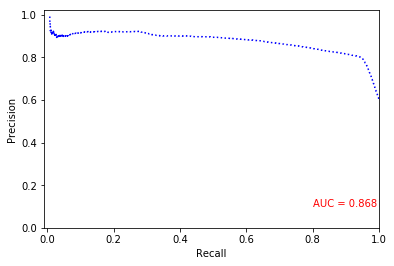

In [38]:
prec, rec, auc = ComputePrecisionRecall(scores=all_scores, 
                            labels=all_labels)
plt.plot(rec, prec, color='b', linestyle='dotted')
plt.text(.8, .1, f'AUC = {auc:.3f}', color='r')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.02])
#plt.savefig('./test_data_dir/results_v3/precision_recall_kaldi.jpg')
plt.show()


In [ ]:
fprs, fnrs, eer = ComputeEER(scores=all_scores, 
                            labels=all_labels)
plt.plot(fprs, fnrs, color='b', linestyle='dotted')
plt.text(eer, eer, f'EER={eer:.3f}')
x = np.arange(0, 100, 1)
plt.plot(x, x, color='r', linestyle='dotted')
plt.xlabel('False postive')
plt.ylabel('False negative')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
#plt.savefig('./test_data_dir/results_v3/eer_kaldi.jpg')
plt.show()

In [136]:
my_prec, my_rec, my_auc, my_thres = my_ComputePrecisionRecall(scores=filt_scores,
                            labels=filt_labs)

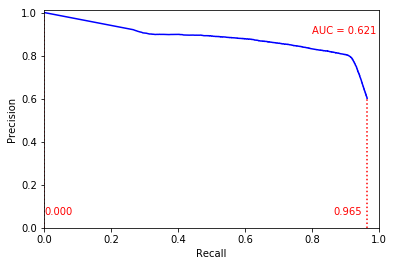

In [72]:
plt.plot(my_rec, my_prec, color='b', linestyle='solid')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([0, 1.0])
plt.ylim([0, 1.01])
min_rec = np.arange(0, max(my_prec), .01)
max_rec = np.arange(0, min(my_prec), .01)
max_prec = np.arange(0, min(my_rec), .01)
plt.plot([min(my_rec)] * len(min_rec), min_rec, linestyle='dotted', color='r')
plt.plot([max(my_rec)] * len(max_rec), max_rec, linestyle='dotted', color='r')
#plt.plot(max_prec, [max(my_prec)] * len(max_prec), linestyle='dotted', color='r')
plt.text(.8, .9, f'AUC = {my_auc:.3f}', color='r')
plt.text(min(my_rec), .06, f'{min(my_rec):.3f}', color='r')
plt.text(max(my_rec)-.1, .06, f'{max(my_rec):.3f}', color='r')
#plt.savefig('./test_data_dir/results_v3/precision_recall_mine_script.jpg')
plt.show()

### Sklearn precison-recall curve

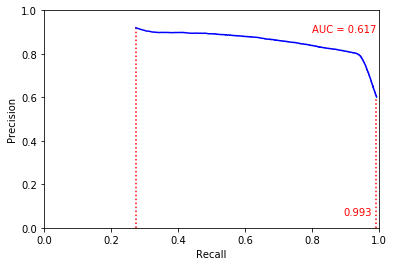

In [139]:
sk_prec, sk_rec, sk_thres = precision_recall_curve(filt_labs, filt_scores)
sk_new_rec = sk_rec * sum(filt_labs) / sum(all_labels)
max_sk_rec = np.arange(0, min(sk_prec), .01)
sk_prec = sk_prec[:-1]
sk_new_rec = sk_new_rec[:-1]
sk_auc = np.abs(np.trapz(sk_prec, sk_new_rec))

min_sk_rec = np.arange(0, max(sk_prec), .01)
plt.plot([min(sk_new_rec)] * len(min_sk_rec), min_sk_rec, linestyle='dotted', color='r')
plt.plot([max(sk_new_rec)] * len(max_sk_rec), max_sk_rec, linestyle='dotted', color='r')
plt.text(.8, .9, f'AUC = {sk_auc:.3f}', color='r')
plt.text(max(sk_new_rec)-.1, .06, f'{max(sk_new_rec):.3f}', color='r')
#plt.text(min(sk_new_rec), .06, f'{min(sk_new_rec):.3f}', color='r')

plt.plot(sk_new_rec, sk_prec, 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Debug: compare true postive and ref word counts

In [ ]:
debug_fname = './test_data_dir/results_v3/debug_tp_counts.txt'
debug_fid = open(debug_fname, 'w')
for w in dict_ref_words_labels.keys():
    debug_tp(debug_fhandle=debug_fid, word=w, scores=dict_ref_words_scores[w],
             labels=dict_ref_words_labels[w])
debug_fid.close()

### Compare my scripts vs. Kaldi min_dcf

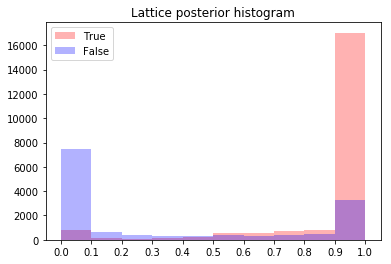

In [83]:
ref_true_scores = np.array(all_scores)[np.where(np.array(all_labels) ==1)]
ref_true_scores = ref_true_scores[np.where(ref_true_scores >= 0)]
ref_false_scores = np.array(all_scores)[np.where(np.array(all_labels) ==0)]
len(ref_true_scores), len(ref_false_scores)
plt.hist(ref_true_scores, bins=10, color='r', alpha=.3)
plt.hist(ref_false_scores, bins=10, color='b', alpha=.3)
plt.xticks(np.arange(11) * .1)
plt.legend(['True', 'False'])
plt.title('Lattice posterior histogram')
plt.show()